In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy import special
import math
import time as toc
%matplotlib inline

In [2]:
a = np.array([-1, -1, -1, 0, 1])

In [3]:
def K(x,s):
    return(np.exp(-(x/s)**2))/s/np.sqrt(np.pi)

In [4]:
def Retina_Mechine_1D(stimulus, sigma_dict, para_dict, dx, dt, loc_dict = 1):
    if loc_dict == 1:
        loc_dict = {}
        loc_dict['C'] = 1
        loc_dict['H'] = 1
        
    klen = max(sigma_dict.values())*5
    xx = np.arange(-klen,klen,dx)
    KC = K(xx,sigma_dict['C'])
    KH = K(xx,sigma_dict['H'])

    output = np.zeros_like(stimulus)#y output
    zts = np.zeros_like(stimulus)#horizontal
    sstm = np.zeros_like(stimulus)
    rpeak = np.zeros(np.shape(stimulus)[0])
    
    if 'tau_y' in sigma_dict.keys():
        T = np.arange(1,int(sigma_dict['tau_y']/dt*8))*dt
        Ky=T/sigma_dict['tau_y'] /sigma_dict['tau_y'] *np.exp(-T/sigma_dict['tau_y'])
        for j in range(np.shape(stimulus)[1]):
            for i in range(len(Ky)-1):
                for ii in range(i+1):
                    sstm[i,j] += stimulus[ii,j]*Ky[i-ii]*dt
            sx = np.convolve(stimulus[:,j],Ky,'valid')*dt
            sstm[len(Ky)-1:,j] = sx.copy()
    else:
        sstm = stimulus.copy()

    for i in range(np.shape(stimulus)[0]-1):
        s = sstm[i,:]
        rs = np.convolve(s,KC,'same')*dx
        ry = np.convolve(output[i,:],KH,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
        rz = np.convolve(zts[i,:],KH,'same')*dx# feedback from horizontal cell (z convoluted with horitonatl cell receptive field KH)

        dyj =(-para_dict['alpha']*output[i,:]+para_dict['k']*(rs-para_dict['phi']*rz))*dt
        dzj =(-para_dict['beta']*zts[i,:]+para_dict['g']*output[i,:])*dt
        output[i+1,:] = (output[i,:]+dyj)*loc_dict['C']
        zts[i+1,:] = (zts[i,:]+dzj)*loc_dict['H']
        
        output[i+1,:] = (output[i+1,:]+np.abs(output[i+1,:]))/2
        zts[i+1,:] = (zts[i+1,:]+np.abs(zts[i+1,:]))/2
        
        maxpos = np.argmax(output[i+1,:])
        rpeak[i+1]= maxpos*dx
    return output, zts, rpeak

In [5]:
def STA(r, x, dt, window):
    negshift=round(window[0]/dt) # second
    posshift=round(window[1]/dt) # second
    xSTS = np.zeros(posshift-negshift)
    for i in np.arange(-negshift, len(r)-posshift):
        xSTS = xSTS + x[i+negshift:i+posshift]*r[i]
        
    xSTA = xSTS/sum(r[-negshift:len(r)-posshift])
    time = np.arange(negshift*dt, posshift*dt, dt)
    return time, xSTA

In [6]:
def Ay(para_dict, sigma_dict, x, n = 1000):
    alpha = para_dict['alpha']
    beta = para_dict['beta']
    k = para_dict['k']
    phi = para_dict['phi']
    g = para_dict['g']
    sigma_h = sigma_dict['H']
    sigma_c = sigma_dict['C']
    ans =  0
    for i in range(n+1):
        ans += k/alpha/np.sqrt(np.pi)*(-k*g/alpha/beta)**i/np.sqrt(sigma_c**2+i*sigma_h**2)*np.exp(-x**2/(sigma_c**2+i*sigma_h**2))
    return ans

In [7]:
sigma_dict = dict()
sigma_dict['H'] = 1
sigma_dict['C'] = sigma_dict['H']*2/3# RF size of cone cell
dx = 0.05*sigma_dict['H']
 
dt=0.01
sigma_dict['tau_y'] = 0.02

In [8]:
#Width setting
xlen = 2000*dx #spatial extend of simulation
hw = 0.75*sigma_dict['H']#half bar width
tempx = np.arange(0,xlen,dx)

In [9]:
para_dict = {}
para_dict['alpha'] = 80
para_dict['beta'] = 2
para_dict['k'] = 100
para_dict['phi'] = 5.0
para_dict['g'] = 40

para_dict['g']*para_dict['k']*para_dict['phi']/para_dict['alpha']/para_dict['beta']

125.0

In [10]:
# x = np.arange(-int(xlen/dx/2),int(xlen/dx/2))*dx
# plt.plot(Ay(para_dict,sigma_dict,x))
# plt.title('Show Analitc Solution of Steady State')

## Whole Field STA

In [11]:
homo_cSTA = np.matmul((np.random.randn(5000)*0.3+2)[:, np.newaxis], np.ones(int(xlen/dx))[np.newaxis, :])
y, zts, _ = Retina_Mechine_1D(homo_cSTA, sigma_dict, para_dict, dx, dt)

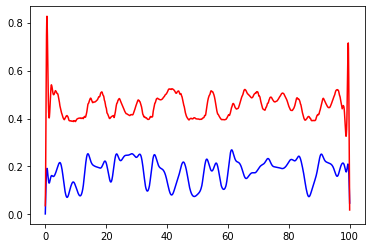

In [12]:
#####PLot numerical solution########
plt.plot(tempx,y.T[:,-1],'b')#numerical solution
plt.plot(tempx,zts.T[:,-1],'r')#numerical solution

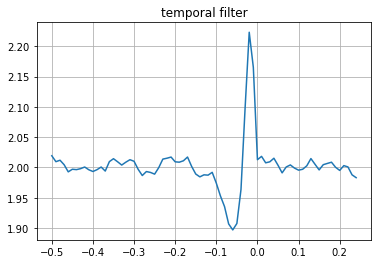

In [13]:
output = y[:,int(xlen/dx/2)]
time, xSTA = STA(output, homo_cSTA[:,0], dt, [-0.5,0.25])
plt.plot(time, xSTA)
plt.title('temporal filter')
plt.grid()

## A Smooth Constant speed Moving Bar

In [14]:
nstep = 1600
moving_bar = np.zeros([nstep, int(xlen/dx)])
pos = 0
v = 0.8 #dx/step
hw = 10 #dx
pos = 600
speak = np.zeros(nstep)
for i in range(nstep):
    pos = pos+v
    moving_bar[i,max(int(pos-hw), 0):min(int(pos+hw), int(xlen/dx))] = 1
    speak[i] = pos*dx

In [15]:
SbS_y, zts, rpeak = Retina_Mechine_1D(moving_bar, sigma_dict, para_dict, dx, dt)

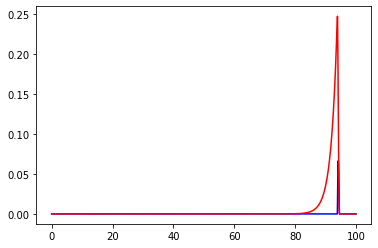

In [16]:
#####PLot numerical solution########
plt.plot(tempx,SbS_y.T[:,-1],'b')#numerical solution
plt.plot(tempx,zts.T[:,-1],'r')#numerical solution

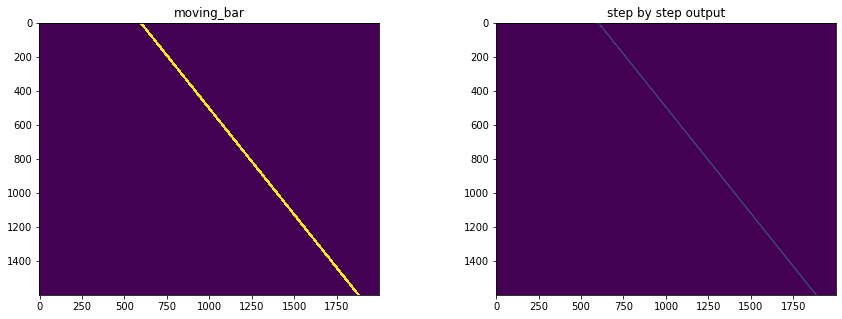

In [17]:
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
ax2.imshow(moving_bar)
ax2.set_title('moving_bar')
ax3.imshow(SbS_y)
ax3.set_title('step by step output')
fig.set_size_inches(15, 5)

Text(0.5, 1.0, 'prediction')

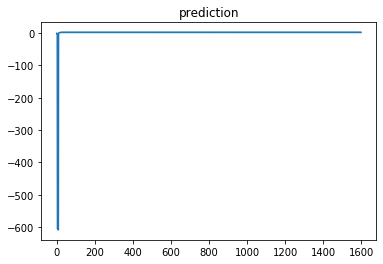

In [18]:
plt.plot(((rpeak-speak)/dx)[1:])
# plt.xlim([100,nstep])
# plt.ylim([-hw,+hw])
plt.title('prediction')

## spatial-temporal Checker 

In [19]:
nstep = 5000
ST_cSTA = np.random.randn(nstep, int(xlen/dx))*0.3
ST_cSTA = ST_cSTA-np.min(ST_cSTA)+0.5
y, zts, _ = Retina_Mechine_1D(ST_cSTA, sigma_dict, para_dict, dx, dt)

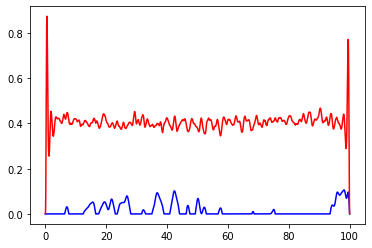

In [20]:
#####PLot numerical solution########
plt.plot(tempx,y.T[:,-1],'b')#numerical solution
plt.plot(tempx,zts.T[:,-1],'r')#numerical solution

In [21]:
tic = toc.time()
time_window = [-0.3,0.1]
nstep = int(np.diff(time_window)/dt)
test2 = np.zeros([nstep, int(xlen/dx)])
test3 = np.zeros([nstep, int(xlen/dx)])
denominator = np.zeros(int(xlen/dx))
step = np.round(np.arange(time_window[0],time_window[1],dt)/dt).astype(int)
ST_cSTA_c = ST_cSTA - np.mean(ST_cSTA)
for i in range(nstep):
    for ii in np.arange(max(-step[i],0), y.shape[0]-1+min(-step[i], 0)):
        test2[i,:] += np.correlate(y[ii,:],ST_cSTA_c[step[i]+ii, :], 'same')
        denominator += np.correlate(y[ii,:],np.ones_like(ST_cSTA[0, :]), 'same')
    test3[i,:] = test2[i,:]/denominator
    denominator = np.zeros(int(xlen/dx))
toc.time()-tic

123.4529197216034

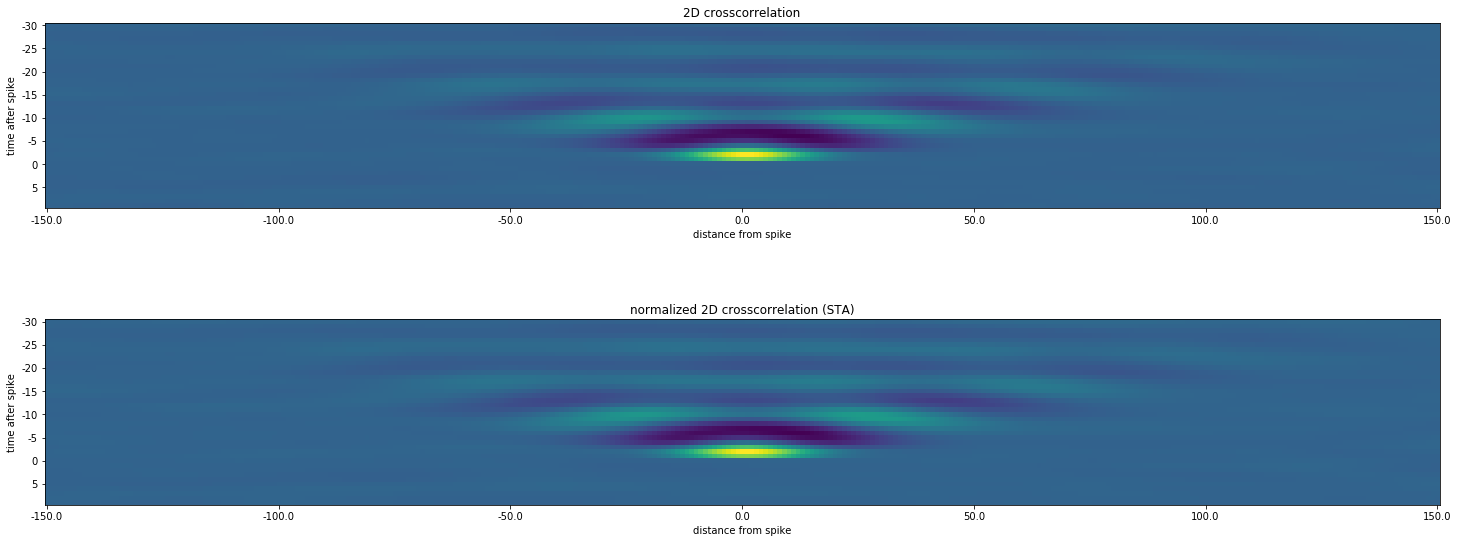

In [22]:
space_window = np.arange(850,1151)
fig, (ax2, ax3) = plt.subplots(nrows=2, ncols=1)
ax2.imshow((test2)[:,space_window])
ax2.set_yticks(np.arange(0,len(step),5))
ax2.set_yticklabels(step[np.arange(0,len(step),5)])
ax2.set_ylabel('time after spike')
ax2.set_xticks(np.arange(0,len(space_window),50))
ax2.set_xticklabels(space_window[np.arange(0,len(space_window),50)]-np.mean(space_window))
ax2.set_xlabel('distance from spike')
ax2.set_title('2D crosscorrelation')
ax3.imshow((test3)[:,space_window])
ax3.set_yticks(np.arange(0,len(step),5))
ax3.set_yticklabels(step[np.arange(0,len(step),5)])
ax3.set_ylabel('time after spike')
ax3.set_xticks(np.arange(0,len(space_window),50))
ax3.set_xticklabels(space_window[np.arange(0,len(space_window),50)]-np.mean(space_window))
ax3.set_xlabel('distance from spike')
ax3.set_title('normalized 2D crosscorrelation (STA)')
fig = plt.gcf()
fig.set_size_inches(25, 10)

choose center cell and a certain time before spike

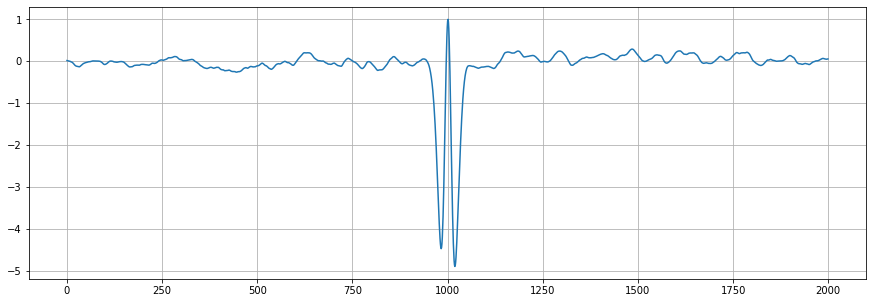

In [23]:
tbs_i = 26
# xx = np.arange(-dx*150,dx*150,dx)
# KKK = K(xx, dx*30)
# smoothtest1 = np.convolve((test1[tbs_i, :]+np.flip(test1[tbs_i, :]))/2,KKK,'same')*dx
# plt.plot(smoothtest1/max(smoothtest1))
plt.plot(test2[tbs_i, :]/max(test2[tbs_i, :]))
plt.grid()
fig = plt.gcf()
fig.set_size_inches(15, 5)

In [24]:
# ST_kernel1 = []
# for i in np.arange(0,np.argmin(np.abs(time))):
#     ST_kernel1.append(np.convolve((test1[i, :]+np.flip(test1[i, :]))/2,KKK,'same')*dx)
# ST_kernel1 = np.flipud(np.array(ST_kernel1))
# ST_kernel1 = ST_kernel1/np.max(ST_kernel1)

In [25]:
ST_kernel2 = []
for i in np.arange(0,np.argmin(np.abs(step))):
    ST_kernel2.append(test2[i,:]+np.flip(test2[i,:]))
ST_kernel2 = np.flipud(np.array(ST_kernel2)/2)
ST_kernel2 = ST_kernel2/np.max(ST_kernel2)

In [26]:
ST_kernel3 = []
for i in np.arange(0,np.argmin(np.abs(step))):
    ST_kernel3.append(test3[i,:]+np.flip(test3[i,:]))
ST_kernel3 = np.flipud(np.array(ST_kernel3)/2)
ST_kernel3 = ST_kernel3/np.max(ST_kernel3)

In [27]:
# fig, (ax2, ax3) = plt.subplots(2,1)
# ax2.imshow(ST_kernel1)
# ax3.imshow(ST_kernel2)
# # plt.imshow(ST_kernel)
# fig = plt.gcf()
# fig.set_size_inches(20, 5)

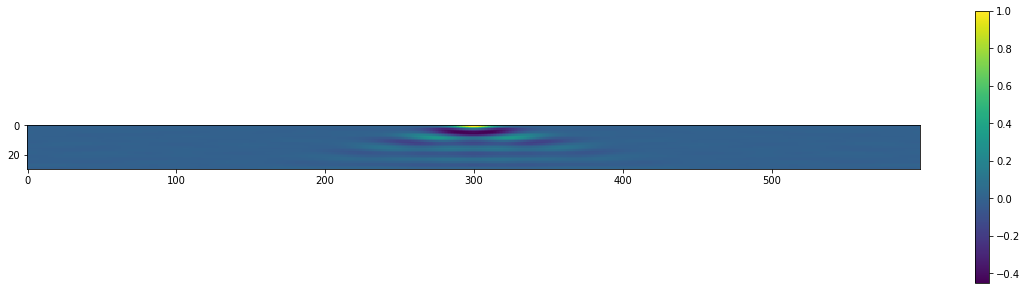

In [28]:
ST_kernel = ST_kernel3
plt.imshow(ST_kernel[:,int(ST_kernel.shape[1]*0.35):int(ST_kernel.shape[1]*0.65)])
plt.colorbar()
# plt.imshow(ST_kernel)
fig = plt.gcf()
fig.set_size_inches(20, 5)

## Simply apply spatial-temporal kernel on moving bar

In [29]:
tic = toc.time()
nstep = 1600
mb_y = np.zeros([nstep, int(xlen/dx)])
for i in range(nstep):
    for ii in np.arange(max(i-np.shape(ST_kernel)[0]+1, 0), i+1):
        mb_y[i,:] += np.convolve(moving_bar[ii,:],ST_kernel[i-ii, :], 'same')
toc.time()-tic

15.37389326095581

In [30]:
#1d scipy.signal.convolve much slower than numpy.convolve (https://github.com/scipy/scipy/issues/5280)
# STK = np.concatenate((np.zeros_like(ST_kernel),ST_kernel), axis = 0)
# np.shape(STK)
# tic = toc.time()
# nstep = 1600
# con2d_y = signal.convolve2d(moving_bar.T, STK.T,  mode='same')
# print(toc.time()-tic)
# plt.imshow(con2d_y.T)

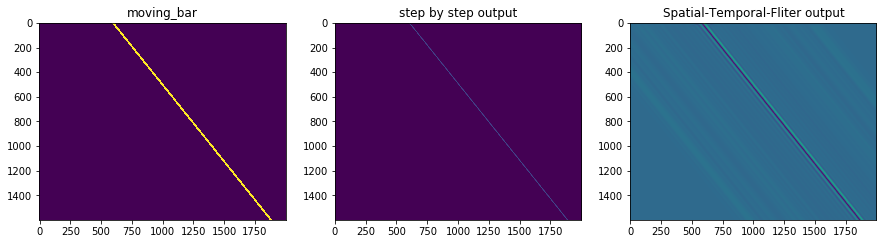

In [31]:
fig, (ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=3) 
ax2.imshow(moving_bar)
ax2.set_title('moving_bar')
ax3.imshow(SbS_y)
ax3.set_title('step by step output')
ax4.imshow(mb_y)
ax4.set_title('Spatial-Temporal-Fliter output')
fig.set_size_inches(15, 5)

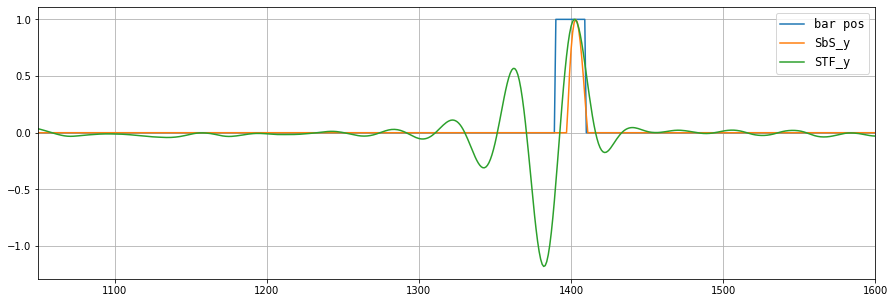

In [32]:
plt.plot(moving_bar[1000,:])
plt.plot(SbS_y[1000,:]/max(SbS_y[1000,:]))
plt.plot(mb_y[1000,:]/max(mb_y[1000,:]))
# plt.plot(con2d_y[1000,:]/max(con2d_y[1000,:]))
plt.grid()
fig = plt.gcf()
plt.legend( ('bar pos', 'SbS_y', 'STF_y'), loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.xlim([1050,1600])
fig.set_size_inches(15, 5)

## Apply SVD on Spatial-Temporal Kernel

In [33]:
from numpy import linalg as la
U,sigma,VT=la.svd(ST_kernel)

In [34]:
sigma/sum(sigma)

array([0.35598477, 0.19535273, 0.11236164, 0.06777274, 0.04528788,
       0.02942285, 0.02235812, 0.01995964, 0.01562549, 0.01521937,
       0.01426687, 0.01273833, 0.01183947, 0.01071808, 0.00926   ,
       0.00916123, 0.00810088, 0.00619882, 0.00608627, 0.00596651,
       0.00407213, 0.00382325, 0.00346036, 0.00302906, 0.00270642,
       0.00242751, 0.00215763, 0.00179124, 0.0014953 , 0.0013554 ])

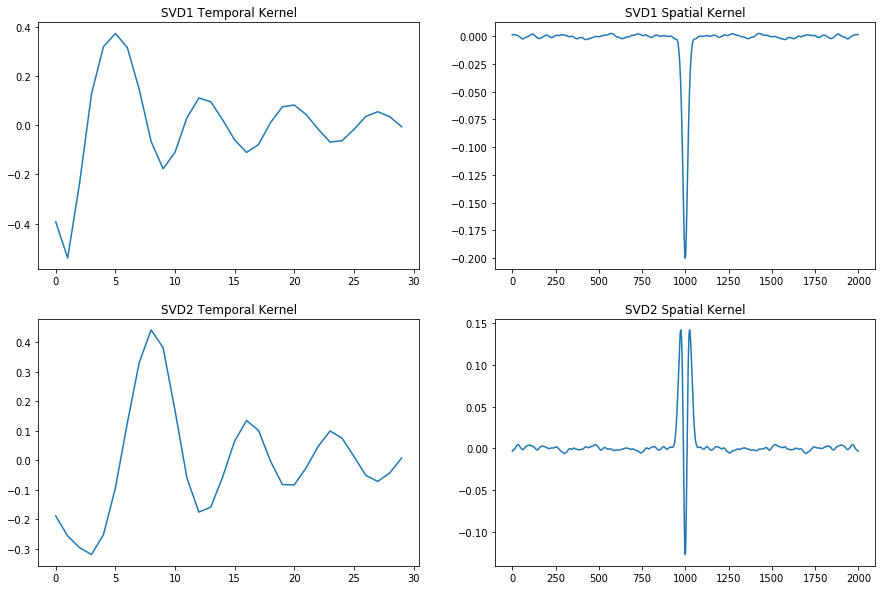

In [35]:
fig, ((ax2, ax3), (ax4, ax5)) = plt.subplots(nrows=2, ncols=2)
ax2.plot(U[:,0])
ax2.set_title('SVD1 Temporal Kernel')
ax3.plot(VT[0,:])
ax3.set_title('SVD1 Spatial Kernel')
ax4.plot(U[:,1])
ax4.set_title('SVD2 Temporal Kernel')
ax5.plot(VT[1,:])
ax5.set_title('SVD2 Spatial Kernel')
fig.set_size_inches(15, 10)

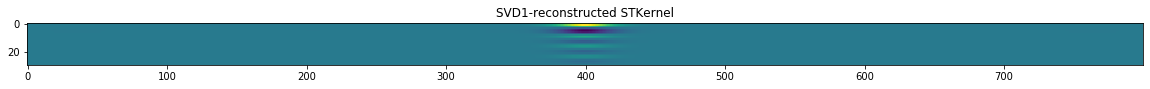

In [36]:
cSVD = 0
SVD_STkernel = np.matmul(U[:,cSVD][:, np.newaxis], VT[cSVD,:][np.newaxis, :])
plt.imshow(SVD_STkernel[:,int(ST_kernel.shape[1]*0.3):int(ST_kernel.shape[1]*0.7)])
plt.title('SVD'+str(cSVD+1)+'-reconstructed STKernel')
fig = plt.gcf()
fig.set_size_inches(20, 5)

In [37]:
nstep = 1600
SVD_STK_y = np.zeros([nstep, int(xlen/dx)])
for i in range(nstep):
    for ii in range(i):
        if (i-ii) < np.shape(ST_kernel)[0]:
            SVD_STK_y[i,:] += np.convolve(moving_bar[ii,:],SVD_STkernel[i-ii, :], 'same')

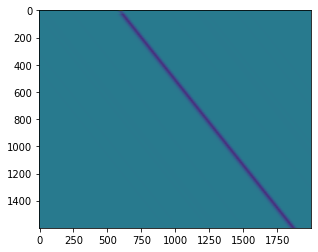

In [38]:
plt.imshow(SVD_STK_y)

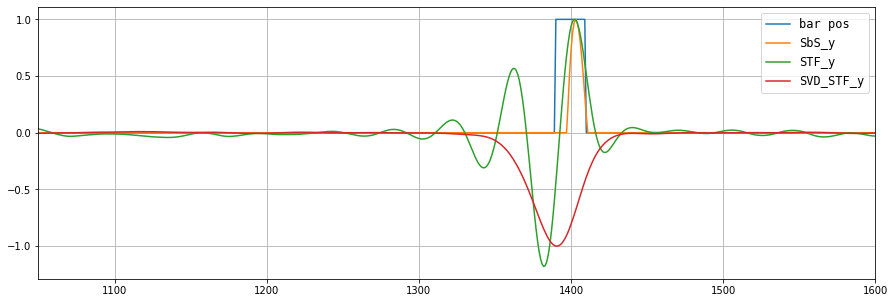

In [39]:
plt.plot(moving_bar[1000,:])
plt.plot(SbS_y[1000,:]/max(SbS_y[1000,:]))
plt.plot(mb_y[1000,:]/max(mb_y[1000,:]))
plt.plot(-SVD_STK_y[1000,:]/min(SVD_STK_y[1000,:]))
plt.grid()
fig = plt.gcf()
plt.legend( ('bar pos', 'SbS_y', 'STF_y', 'SVD_STF_y'), loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.xlim([1050,1600])
fig.set_size_inches(15, 5)

In [40]:
A_y = Ay(para_dict,sigma_dict,x)
plt.plot(A_y[149:]/max(A_y))
plt.plot(VT[0,:]/min(VT[0,:]))

NameError: name 'x' is not defined

In [ ]:
A_y = Ay(para_dict,sigma_dict,x)
len(VT[0,:] )

In [ ]:
np.argmax(A_y[149:])

In [ ]:
A_y[999], A_y[1000], A_y[1001]

## Checking nonlinearity by linear combination

In [ ]:
nstep = 1600
moving_bar2 = np.zeros([nstep, int(xlen/dx)])
v = 0.8#dx/step
hw = 30 #dx
pos = 1800
speak = np.zeros(nstep)
for i in range(nstep):
    pos = pos-v
    moving_bar2[i,max(int(pos-hw), 0):min(int(pos+hw), int(xlen/dx))] = 1
#     speak[i] = pos*dt

In [ ]:
SbS_y2, zts, rpeak = Retina_Mechine_1D(moving_bar2, sigma_dict, para_dict, dx, dt)

In [ ]:
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
ax2.imshow(moving_bar2)
ax2.set_title('moving_bar2')
ax3.imshow(SbS_y2)
ax3.set_title('step by step output2')
fig.set_size_inches(15, 5)

In [ ]:
SbS_y3, zts, rpeak = Retina_Mechine_1D(moving_bar2+moving_bar, sigma_dict, para_dict, dx, dt)

In [ ]:
fig, (ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=3) 
ax2.imshow(moving_bar2+moving_bar)
ax2.set_title('moving_bar1+2')
ax3.imshow(SbS_y3)
ax3.set_title('step by step output3')
ax4.imshow(SbS_y+SbS_y2)
ax4.set_title('step by step output1+2')
fig.set_size_inches(15, 5)

In [ ]:
plt.plot((moving_bar2+moving_bar)[1500,:])
plt.plot(SbS_y3[1500,:]/max(SbS_y3[1500,:]))
plt.plot((SbS_y+SbS_y2)[1500,:]/max((SbS_y+SbS_y2)[1500,:]))
plt.grid()
fig = plt.gcf()
# plt.legend( ('bar pos', 'SbS_y', 'STF_y', 'SVD_STF_y'), loc='best', prop={'size': 'large', 'family': 'monospace'})
# plt.xlim([750,1500])
fig.set_size_inches(15, 5)

In [ ]:
plt.imshow(SbS_y3 == SbS_y+SbS_y2)

In [ ]:
tic = toc.time()
nstep = 1600
mb_y2 = np.zeros([nstep, int(xlen/dx)])
for i in range(nstep):
    for ii in np.arange(max(i-np.shape(ST_kernel)[0]+1, 0), i+1):
        mb_y2[i,:] += np.convolve(moving_bar2[ii,:],ST_kernel[i-ii, :], 'same')
toc.time()-tic

In [ ]:
tic = toc.time()
nstep = 1600
mb_y3 = np.zeros([nstep, int(xlen/dx)])
for i in range(nstep):
    for ii in np.arange(max(i-np.shape(ST_kernel)[0]+1, 0), i+1):
        mb_y3[i,:] += np.convolve(moving_bar2[ii,:]+moving_bar[ii,:],ST_kernel[i-ii, :], 'same')
toc.time()-tic

In [ ]:
fig, (ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=3) 
ax2.imshow(moving_bar2+moving_bar)
ax2.set_title('moving_bar1+2')
ax3.imshow(mb_y3)
ax3.set_title('step by step output3')
ax4.imshow(mb_y+mb_y2)
ax4.set_title('step by step output1+2')
fig.set_size_inches(15, 5)

In [ ]:
plt.imshow(mb_y3 == mb_y+mb_y2)